## 2. Метод Хафа для поиска окружностей и других кривых общего вида.

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import collections
from tqdm.notebook import tqdm

### Описание алгоритма

Метод Хафа основывается на представлении искомого объекта в виде параметрического уравнения. Для каждой точки перебираются все возможные параметры и инфомация о возможной принадлежности точки данной кривой сохранятеся в аккумуляторный массив (точка "голосует" за данную кривую). В итоге наиболее возможной кривой будет та, которая набрала наибольшее количество "голосов" в аккумуляторном массиве.

### Реализации алгоритмов

##### Функция для выделения прямых (отрезков):

In [2]:
def HoughLineDetector(img, angle_precision, distantce_precision):
    height, width = img.shape[:2]
    dist = np.sqrt(np.square(height) + np.square(width))
    
    angles = np.arange(0, 180, angle_precision)
    
    distances = np.arange(-dist, dist, distantce_precision)
    
    angel_cos = np.cos(np.deg2rad(angles))
    angel_sin = np.sin(np.deg2rad(angles))
    
    accumulator = np.zeros((distances.shape[0], angles.shape[0]), dtype=float)    
    points = collections.defaultdict(list)
        
    for x in tqdm(range(0, width)):
        for y in range(0, height):
            if img[y, x] != 0:
                for angle_ind in range(angles.shape[0]):
                    cur_distance = x * angel_cos[angle_ind] + y * angel_sin[angle_ind]
                    distance_ind = (np.abs(distances - cur_distance)).argmin()
                    accumulator[distance_ind, angle_ind] += 1
                    points[distance_ind, angle_ind].append((x, height - y))
                    
    return accumulator, points, angles, distances
    

##### Функция для выделения окружностей:

In [3]:
def HoughCircleDetector(img, angle_precision, distance_precision):
    height, width = img.shape[:2]
    dist = np.sqrt(np.square(height) + np.square(width))
    
    angles = np.arange(0, 360, angle_precision)
    
    distances = np.arange(0, dist,  distance_precision)
    
    angle_cos = np.cos(np.deg2rad(angles))
    angle_sin = np.sin(np.deg2rad(angles))
    
    accumulator = np.zeros((width, height, distances.shape[0]), dtype=float)
    for x in tqdm(range(0, width)):
        for y in range(0, height):
            if img[y, x] != 0:
                for cur_distance in range(distances.shape[0]):
                    for cur_angel in range(angles.shape[0]):
                        cur_x = x - distances[cur_distance] * angle_cos[cur_angel]
                        cur_y = y - distances[cur_distance] * angle_sin[cur_angel]
                        if x != cur_x and y != cur_y:
                            if 0 <= int(cur_x) < width and 0 <= int(cur_y) < height:
                                accumulator[int(cur_x), int(cur_y), cur_distance] += 1
            
    return accumulator, distances


### Демонстрация:

In [4]:
img1 = cv.imread('images/test1.png', cv.IMREAD_GRAYSCALE)

result1 = HoughCircleDetector(img1, 1, 3)

In [6]:
img = cv.imread('images/test.png', cv.IMREAD_GRAYSCALE)

result2, points1, angels1, distances1 = HoughLineDetector(img, 1, 1)

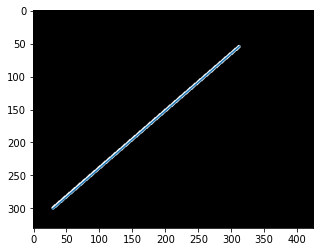

In [7]:
index = np.unravel_index(result2.argmax(), result2.shape)
line_points = np.sort(points1[index], 0)

plt.imshow(img, cmap='gray')

line = plt.Line2D((line_points[-1][0], line_points[0][0]), (img.shape[0] - line_points[-1][1], img.shape[0] - line_points[0][1]))
plt.gca().add_artist(line)
plt.show()

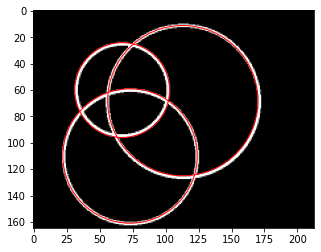

In [39]:
plt.imshow(img1, cmap='gray')

indices = np.dstack(np.unravel_index(np.argsort(np.ravel(result1[0])), result1[0].shape))

circle1 = plt.Circle((indices[0][-1][0], indices[0][-1][1]), result1[1][indices[0][-1][2]], fill=False, color='red')
circle2 = plt.Circle((indices[0][-2][0], indices[0][-2][1]), result1[1][indices[0][-2][2]], fill=False, color='red')
circle3 = plt.Circle((indices[0][-3][0], indices[0][-3][1]), result1[1][indices[0][-3][2]], fill=False, color='red')

plt.gca().add_artist(circle1)
plt.gca().add_artist(circle2)
plt.gca().add_artist(circle3)

plt.show()

Видно что нам удалось определить кривые на исходном изображении.

### Реализация с помощью OpenCV

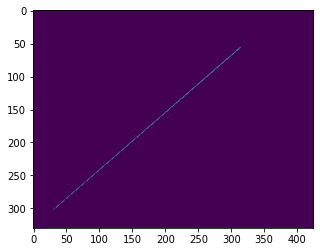

In [9]:
import math

cdst = img.copy()
lines = cv.HoughLines(img, 1, np.pi / 180, 150, None, 0, 0)
    
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv.line(cdst, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
        
plt.imshow(cdst)
plt.show()

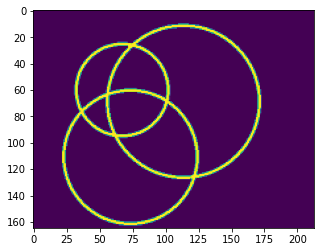

In [10]:
src = img1.copy()

circles = cv.HoughCircles(img1, cv.HOUGH_GRADIENT, 1, src.shape[0] / 8,
                           param1=100, param2=30,
                           minRadius=1, maxRadius=30)


if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv.circle(src, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = i[2]
        cv.circle(src, center, radius, (255, 0, 255), 3)
        
plt.imshow(src)
plt.show()

### Анализ полученных данных

In [37]:
p1 = (line_points[0, 0], line_points[0, 1])
p2 = (line_points[-1, 0], line_points[-1, 1])
print("Найден отрезок с координатами", p1, "и", p2)

x = p2[0] - p1[0]
y = p2[1] - p1[1]
seg_len = (x ** 2 + y ** 2) ** 0.5
print("Длина отрезка: {0:.3f}".format(seg_len))
print("Длина проекции на ось OX: ", x)
print("Длина проекции на ось OY: ", y)

print("Тангенс угла наклона отрезка к оси OX (первая производная): {0:.3f}".format(y / x))
seg_ang = math.atan(y / x) / math.pi * 180
print("Угол наклона отрезка к оси OX (deg): {0:.3f}".format(seg_ang))

seg_margin = p1[1] - y / x * p1[0]
print("Точка пересечения прямой, которой принадлежит отрезок с осью OY: ({0:.3f}, 0)".format(seg_margin))
      
print("Уравнение прямой, которой принадлежит отрезок: y = {0:.3f}x + {1:.3f}".format(y / x, seg_margin))

Найден отрезок с координатами (29, 29) и (313, 276)
Длина отрезка: 376.384
Длина проекции на ось OX:  284
Длина проекции на ось OY:  247
Тангенс угла наклона отрезка к оси OX (первая производная): 0.870
Угол наклона отрезка к оси OX (deg): 41.014
Точка пересечения прямой, которой принадлежит отрезок с осью OY: (3.778, 0)
Уравнение прямой, которой принадлежит отрезок: y = 0.870x + 3.778


In [52]:
circles = [[indices[0][-1][0], indices[0][-1][1], int(result1[1][indices[0][-1][2]])],
            [indices[0][-2][0], indices[0][-2][1], int(result1[1][indices[0][-2][2]])],
             [indices[0][-3][0], indices[0][-3][1], int(result1[1][indices[0][-3][2]])]]
             
print("Найдено {0} окружностей:".format(len(circles)))
for i in range(len(circles)):
    print("Окружность {0} находится в точке {1} и имеет радиус {2}".format(i + 1,
                                                                           (circles[i][0], circles[i][1]),
                                                                           circles[i][2]))

print("\nПересечения окружностей: ")
for i in range(len(circles)):
    for j in range(i + 1, len(circles)):
        coef_x = (circles[j][0] - circles[i][0])
        coef_y = (circles[j][1] - circles[i][1])
        coef_r = circles[i][2]
        coef_a = -2 * coef_x
        coef_b = -2 * coef_y
        coef_c = coef_x ** 2 + coef_y ** 2 + circles[i][2] ** 2 - circles[j][2] ** 2
        coef_x0 = -coef_a * coef_c / (coef_a ** 2 + coef_b ** 2)
        coef_y0 = -coef_b * coef_c / (coef_a ** 2 + coef_b ** 2)
        
        if coef_c ** 2 > coef_r * coef_r * (coef_a ** 2 + coef_b ** 2):
            print("Окружности {0} и {1} не пересекаются".format(i + 1, j + 1))
        elif coef_c ** 2 == coef_r * coef_r * (coef_a ** 2 + coef_b ** 2):
            print("Окружности {0} и {1} пересекаются в точке {2}".format(i + 1,
                                                                         j + 1,
                                                                         (coef_x0, coef_y0)))
        else:
            coef_d = coef_r ** 2 - (coef_c ** 2)/(coef_a ** 2 + coef_b ** 2)
            coef_mult = (coef_d / (coef_a ** 2 + coef_b ** 2)) ** 0.5;
            coef_ax = coef_x0 + coef_b * coef_mult + circles[i][0]
            coef_bx = coef_x0 - coef_b * coef_mult + circles[i][0]
            coef_ay = coef_y0 - coef_a * coef_mult + circles[i][1]
            coef_by = coef_y0 + coef_a * coef_mult + circles[i][1]
            print("Окружности {0} и {1} пересекаются в точках".format(i + 1, j + 1),
                  "({0:.3f}, {1:.3f})".format(coef_ax, coef_ay),
                  "({0:.3f}, {1:.3f})".format(coef_bx, coef_by))
            

Найдено 3 окружностей:
Окружность 1 находится в точке (73, 110) и имеет радиус 51
Окружность 2 находится в точке (113, 68) и имеет радиус 57
Окружность 3 находится в точке (67, 60) и имеет радиус 36

Пересечения окружностей: 
Окружности 1 и 2 пересекаются в точках (121.957, 124.292) (56.338, 61.798)
Окружности 1 и 3 пересекаются в точках (102.077, 68.101) (34.836, 76.170)
Окружности 2 и 3 пересекаются в точках (75.549, 25.030) (63.241, 95.803)
